<a href="https://colab.research.google.com/github/ItayTol/Personslity_Classifier/blob/main/Personality__Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA & Preproessing

For loading data from huggingface

In [42]:
!pip install datasets --quiet

In [43]:
from datasets import load_dataset
import matplotlib.pyplot as plt, seaborn as sns, pandas as pd, os
from tensorflow.keras.utils import text_dataset_from_directory, plot_model
from tensorflow.keras.metrics import Precision, Recall, Accuracy
import tensorflow as tf

Importing our raw dataset

In [44]:
df_raw  = pd.DataFrame(load_dataset("Fatima0923/Automated-Personality-Prediction", split='all'))

In [45]:
df_raw.head(5)

,text,agreeableness,openness,conscientiousness,extraversion,neuroticism
0,his name was kim kimble originally wow thats s...,9.0,61.0,13.0,4.0,72.0
1,theyre better than the normal posts on ryugioh...,50.0,85.0,50.0,85.0,50.0
2,how the fuck does this even happen hi youre cu...,15.0,85.0,15.0,85.0,15.0
3,it probably does ive learned a lot about mysel...,71.0,53.0,17.0,3.0,31.0
4,yea those are the same sound to me still,64.0,44.0,33.0,8.0,88.0


At first look it seems there are 20,877 texts in the data

In [46]:
print('Number of records:', df_raw.shape[0])

Number of records: 20877


## Removing duplicates records

As we look closer at the data, we spot several records that repeats tens of times with the same scores

For example, the sentence 'gop math wrong wrong right' repeats 20 times

In [47]:
duplicates_example = df_raw[df_raw['text'] == 'gop math wrong wrong right'].reset_index()
print(f"'gop math wrong wrong right' appears in dataset {len(duplicates_example)} times")

'gop math wrong wrong right' appears in dataset 20 times


We'll remove duplicates from data

In [48]:
df_raw_uniques = df_raw.drop_duplicates()
df_raw_uniques=df_raw_uniques.reset_index(drop=True)

After removing duplicates, in the complete dataset there are 17,009 non-repeating records

In [49]:
print("Number of unique records in the complete dataset:", df_raw_uniques.shape[0])

Number of unique records in the complete dataset: 17009


## Customization of Extraversion

In this work there will be an attempt to classify the **extraversion**

The numerical values of extraversion will be replaced by 2 classes: 'Introverted', 'Extroverted'.
*   Introverted -> under 50 points
*   Extroverted -> equal to or above 50 points  




In [51]:
def float_to_label(df):
  bins = [-1, 50, 100]
  labels = ['Introverted', 'Extroverted']
  s = pd.cut(df['extraversion'], bins=bins, labels=labels).to_list()
  return s

df = pd.DataFrame()
df['text']=df_raw_uniques['text'].copy()
df['label']=float_to_label(df_raw_uniques)

mapping_labels = {'Introverted':0, 'Extroverted':1}
df['label_code'] = df['label'].map(mapping_labels)

df[['text', 'label_code']].head(5)

,text,label_code
0,his name was kim kimble originally wow thats s...,0
1,theyre better than the normal posts on ryugioh...,1
2,how the fuck does this even happen hi youre cu...,1
3,it probably does ive learned a lot about mysel...,0
4,yea those are the same sound to me still,0


## Preprocessing texts

*   Removing stopwords and punctuations
*   Stemming *words*

In [52]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import string
import nltk

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
punctuations = set(string.punctuation)

extroverted_texts = list(df['text'][df['label'] == 'Extroverted'])
introverted_texts = list(df['text'][df['label'] == 'Introverted'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [53]:
from collections import Counter

# For automating tokenization, removing punctuation + stop words and stemming
def tokenize(li: list):
    words=[]
    for sentence in li:
        tokenized_sentence = word_tokenize(sentence)
        words.extend([word.lower() for word in tokenized_sentence
                        if word.lower() not in stop_words and word.lower() not in punctuations])
        ps = PorterStemmer()
    words_stemmed = [ps.stem(word) for word in words]
    return words_stemmed

# Counter of words from tokenized corpus
def word_count_in_corpus(li: list):
    words=tokenize(li)
    word_counts = Counter(words)
    return word_counts

# Plot bar plot showing occurences for 20 most common words in a corpus
def plot_most_common_words_in_corpus(li: list, corpus_name: str, bar_color: str):
    word_count=word_count_in_corpus(li)
    most_common_words = word_count.most_common(20)
    plt.bar(*zip(*most_common_words), color=bar_color)
    plt.xlabel('Unigrams')
    plt.ylabel('Frequency')
    plt.title(f'Unigrams Counts in {corpus_name} Corpus')
    plt.xticks(rotation=45)

## Splitting data

Split data to train, validation and test sets

We'll keep the proportions between the labels the same in the datasets

train : validation : test = 0.75 : 0.15 : 0.1

train : validation : test =  12,765 : 2,551 : 1702 records

In [54]:
from sklearn.model_selection import train_test_split

train, val_test = train_test_split(df, test_size=0.25, shuffle=True, stratify=df['label'])
validation, test = train_test_split(val_test, test_size=0.4, shuffle=True, stratify=val_test['label'])

## Choosing a model

Based on the finger rule of choosing a model: We'll use Bag of Words to classify the texts to introverted / extroverted

In [55]:
word_count = [len(x.split()) for x in train['text']]

num_samples = len(train['text'])
mean_sample_length = sum(word_count)/len(word_count)

ratio = num_samples / mean_sample_length
print("Ratio between number of samples and mean sample size:", ratio)

Ratio between number of samples and mean sample size: 271.0326507360657


## Data Statistics

We'll show the most common unigrams and bigrams

The most common word is 'like' with nearly 5000 occurences

By looking at both bar charts, most common words appear in both.



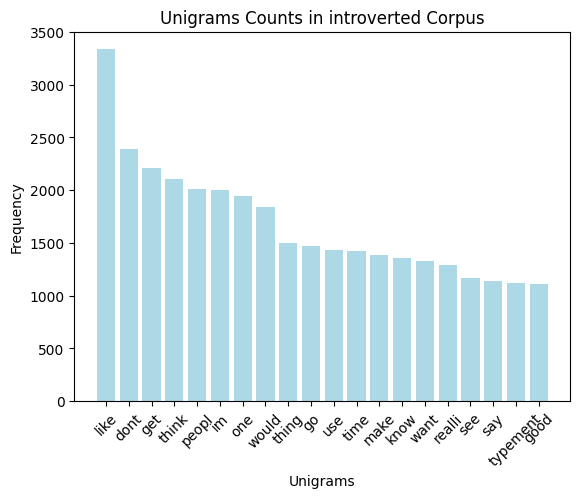

In [56]:
plot_most_common_words_in_corpus(introverted_texts, "introverted", 'lightblue')

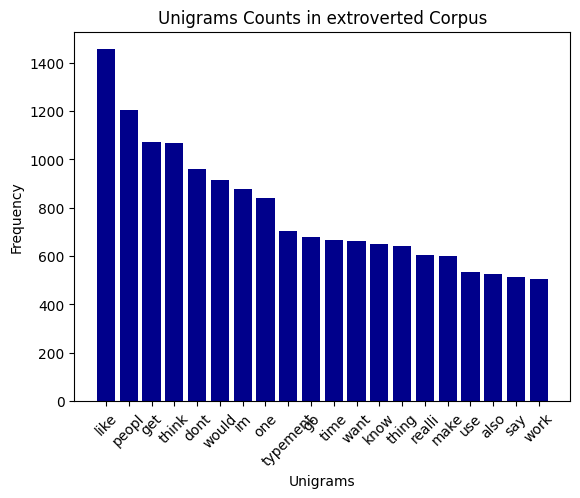

In [15]:
plot_most_common_words_in_corpus(extroverted_texts, "extroverted", 'darkblue')

Most common bigrams of introvrted are 'dont know', 'dont think'.
With bigrams we spot that the word 'dont' repeats itself numerous times in different contexts.

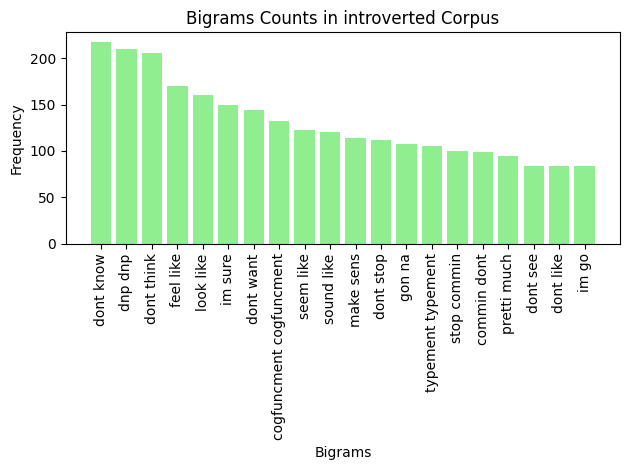

In [16]:
from collections import Counter
introverted_words = tokenize(introverted_texts)
introverted_bigrams = zip(introverted_words, introverted_words[1:])
introverted_counts_bigrams = Counter(introverted_bigrams)
introverted_most_common_bigrams = introverted_counts_bigrams.most_common(20)

introverted_bigrams_text = [f"{bigram[0][0]} {bigram[0][1]}" for bigram in introverted_most_common_bigrams]
introverted_bigrams_occurence = [occurence[1] for occurence in introverted_most_common_bigrams]

plt.bar(introverted_bigrams_text, introverted_bigrams_occurence, color='lightgreen')
plt.xlabel('Bigrams')
plt.ylabel('Frequency')
plt.title('Bigrams Counts in introverted Corpus')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

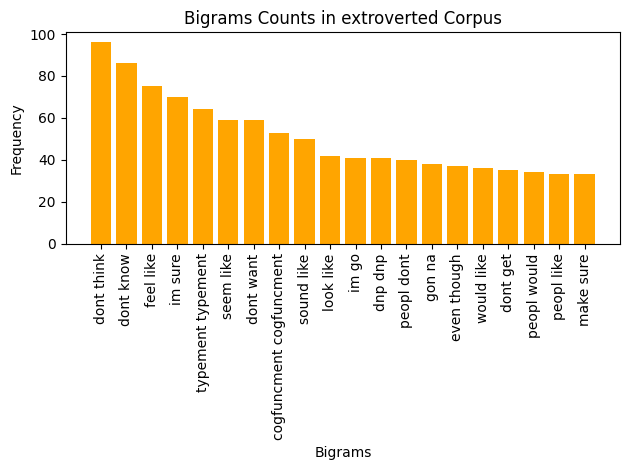

In [17]:
from collections import Counter
extroverted_words = tokenize(extroverted_texts)
extroverted_bigrams = zip(extroverted_words, extroverted_words[1:])
extroverted_counts_bigrams = Counter(extroverted_bigrams)
extroverted_most_common_bigrams = extroverted_counts_bigrams.most_common(20)

extroverted_bigrams_text = [f"{bigram[0][0]} {bigram[0][1]}" for bigram in extroverted_most_common_bigrams]
extroverted_bigrams_occurence = [occurence[1] for occurence in extroverted_most_common_bigrams]

plt.bar(extroverted_bigrams_text, extroverted_bigrams_occurence, color='orange')
plt.xlabel('Bigrams')
plt.ylabel('Frequency')
plt.title('Bigrams Counts in extroverted Corpus')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

There are twice as much introverts than extroverts in the data.

We'll keep that in mind when analyzing prediction results.

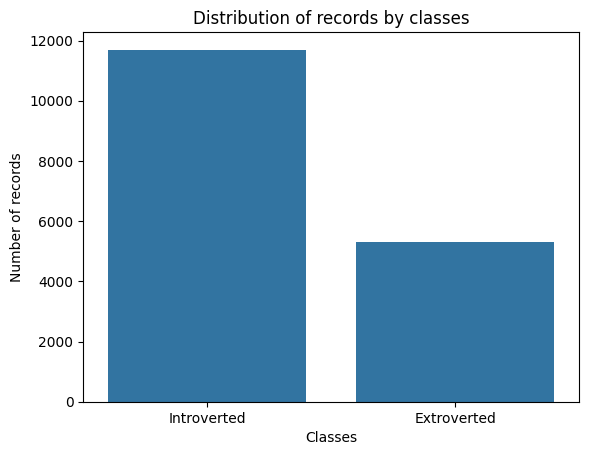

In [18]:
import matplotlib.pyplot as plt
sns.countplot(x = df['label'])
plt.xlabel('Classes')
plt.ylabel('Number of records')
plt.title('Distribution of records by classes')
plt.show()

Introverts tend to express more in writing than extroverts

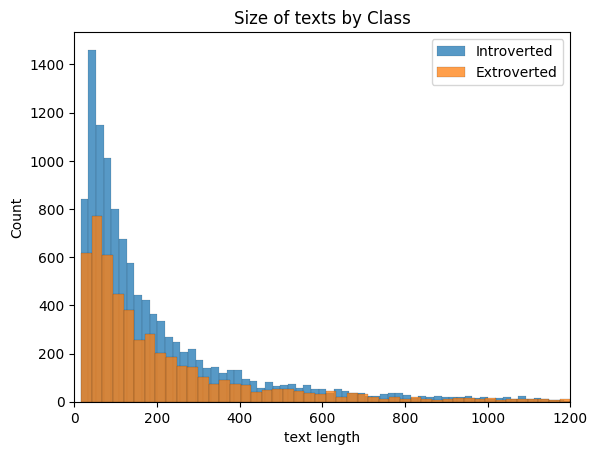

In [19]:
df['text length'] = df['text'].apply(lambda x:len(x))
introverted_text_lengths = df['text length'][df['label']=="Introverted"]
extroverted_text_lengths = df['text length'][df['label']=="Extroverted"]
sns.histplot(x=introverted_text_lengths)
sns.histplot(x=extroverted_text_lengths)
plt.title("Size of texts by Class")
plt.xlim(0,1200)
plt.legend(["Introverted", "Extroverted"])
plt.show()

# Random model

Before preparing a model, especially a deep learning model, it's important to define the baseline

For that We'll shuffle the whole data and calculate accuracy of forecasting

where:
*   train set = original
*   test set = shuffled

Without any sofisticated model, we get 57.4% accuracy

We don't calculate precision and recall because true positive classification for the two classes is equaly important so those metrics are not relevant to this case

In [20]:
import random
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

original_labels = df['label']
shuffled_labels = original_labels.to_list()
random.shuffle(shuffled_labels)

accuracy = accuracy_score(original_labels, shuffled_labels)
print("Accuracy of Random Model:", accuracy)

Accuracy of Random Model: 0.5744605796931036


It's harder for the random model to classify correctly Introverted texts compared to classifying correctly Extroverted texts

In [21]:
cm = confusion_matrix(original_labels, shuffled_labels)
pd.DataFrame(cm, index = ['True Introverted', 'True Extroverted'], columns = ['Predicted Introverted', 'Predicted Extroverted'])

,Predicted Introverted,Predicted Extroverted
True Introverted,1696,3619
True Extroverted,3619,8075


# Bag of Words

Now we'll see if BoW can beat our random model and by how much.

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from tensorflow import keras
import numpy as np

## Testing different hyperparams

We'll test three options for max_tokens: number of features

1.   500 features
2.   1000 features
3.   2000 features

Checking options for max_tokens to increase accuracy

In [36]:
def vectorizer_n_tokens(max_tokens: int):
    vectorizer = keras.layers.TextVectorization(max_tokens=max_tokens,
                                                output_mode='tf-idf',
                                                standardize="lower_and_strip_punctuation")
    vectorizer.adapt(train['text'])

    X_train = vectorizer(train['text'])
    X_val = vectorizer(validation['text'])
    X_test = vectorizer(test['text'])

    y_train = np.array(train['label_code'])
    y_val = np.array(validation['label_code'])
    y_test = np.array(test['label_code'])

    return X_train, X_val, X_test, y_train, y_val, y_test

Complie function ready to use

In [34]:
def complie_(model):
    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

Defining the nn layers for binary classification


In [24]:
def build_BoW_model(dense_units: int, drop_prcnt: float):
    inputs = keras.layers.Input(shape=(X_train.shape[1],), name='input_layer')
    net = keras.layers.Dense(dense_units, activation='relu', name='dense1')(inputs)
    net = keras.layers.Dropout(drop_prcnt, name='dropout1')(net)
    net = keras.layers.Dense(dense_units, activation='relu', name='dense2')(net)
    net = keras.layers.Dropout(drop_prcnt, name='dropout2')(net)
    outputs = keras.layers.Dense(1, activation='sigmoid', name='output_layer')(net)
    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

Checking  **500 features** with options for size of dense layers and dropout perncent

In [30]:
X_train, X_val, X_test, y_train, y_val, y_test = vectorizer_n_tokens(500)
for dense in [64, 128]:
    for prcnt in [0.3, 0.5, 0.8]:
        BoW_model = build_BoW_model(dense, prcnt)
        complie_(BoW_model)

        history = BoW_model.fit(X_train, y_train, verbose=0,
                            batch_size=32, epochs=10,
                            validation_data=(X_val, y_val))
        print(dense, prcnt, "Accuracy:", BoW_model.evaluate(X_test, y_test)[1])

54/54 [==============================] - 0s 2ms/step - loss: 0.7119 - accuracy: 0.6475
64 0.3 Accuracy: 0.6474735736846924
54/54 [==============================] - 0s 2ms/step - loss: 0.6364 - accuracy: 0.6804
64 0.5 Accuracy: 0.6803760528564453
54/54 [==============================] - 0s 2ms/step - loss: 0.6195 - accuracy: 0.6874
64 0.8 Accuracy: 0.6874265670776367
54/54 [==============================] - 0s 2ms/step - loss: 0.7478 - accuracy: 0.6639
128 0.3 Accuracy: 0.6639248132705688
54/54 [==============================] - 0s 2ms/step - loss: 0.6475 - accuracy: 0.6769
128 0.5 Accuracy: 0.6768507361412048
54/54 [==============================] - 0s 4ms/step - loss: 0.6186 - accuracy: 0.6874
128 0.8 Accuracy: 0.6874265670776367


Checking  **1000 features** with options for size of dense layers and dropout perncent

In [31]:
X_train, X_val, X_test, y_train, y_val, y_test = vectorizer_n_tokens(1000)
for dense in [64, 128]:
    for prcnt in [0.3, 0.5, 0.8]:
        BoW_model = build_BoW_model(dense, prcnt)
        complie_(BoW_model)

        history = BoW_model.fit(X_train, y_train, verbose=0,
                            batch_size=32, epochs=10,
                            validation_data=(X_val, y_val))
        print(dense, prcnt, "Accuracy:", BoW_model.evaluate(X_test, y_test)[1])

54/54 [==============================] - 0s 4ms/step - loss: 0.8532 - accuracy: 0.6357
64 0.3 Accuracy: 0.6357226967811584
54/54 [==============================] - 0s 2ms/step - loss: 0.7092 - accuracy: 0.6739
64 0.5 Accuracy: 0.6739130616188049
54/54 [==============================] - 0s 4ms/step - loss: 0.6229 - accuracy: 0.6874
64 0.8 Accuracy: 0.6874265670776367
54/54 [==============================] - 0s 3ms/step - loss: 0.8873 - accuracy: 0.6357
128 0.3 Accuracy: 0.6357226967811584
54/54 [==============================] - 0s 2ms/step - loss: 0.7512 - accuracy: 0.6604
128 0.5 Accuracy: 0.6603995561599731
54/54 [==============================] - 0s 3ms/step - loss: 0.6211 - accuracy: 0.6904
128 0.8 Accuracy: 0.6903643012046814


Checking  **2000 features** with options for size of dense layers and dropout perncent

In [32]:
X_train, X_val, X_test, y_train, y_val, y_test = vectorizer_n_tokens(2000)
for dense in [64, 128]:
    for prcnt in [0.3, 0.5, 0.8]:
        BoW_model = build_BoW_model(dense, prcnt)
        complie_(BoW_model)

        history = BoW_model.fit(X_train, y_train, verbose=0,
                            batch_size=32, epochs=10,
                            validation_data=(X_val, y_val))
        print(dense, prcnt, "Accuracy:", BoW_model.evaluate(X_test, y_test)[1])

54/54 [==============================] - 0s 5ms/step - loss: 1.0302 - accuracy: 0.6240
64 0.3 Accuracy: 0.6239718198776245
54/54 [==============================] - 0s 3ms/step - loss: 0.7622 - accuracy: 0.6610
64 0.5 Accuracy: 0.6609870791435242
54/54 [==============================] - 0s 4ms/step - loss: 0.6216 - accuracy: 0.6874
64 0.8 Accuracy: 0.6874265670776367
54/54 [==============================] - 0s 3ms/step - loss: 1.0960 - accuracy: 0.6475
128 0.3 Accuracy: 0.6474735736846924
54/54 [==============================] - 0s 2ms/step - loss: 0.8416 - accuracy: 0.6410
128 0.5 Accuracy: 0.641010582447052
54/54 [==============================] - 0s 2ms/step - loss: 0.6229 - accuracy: 0.6904
128 0.8 Accuracy: 0.6903643012046814


Out of all models, highest accuracy is when max_tokens=1000, sizes of dense layers are 128 and dropout is 0.8

In [39]:
X_train, X_val, X_test, y_train, y_val, y_test = vectorizer_n_tokens(1000)

best_BoW_model = build_BoW_model(128, 0.8)

complie_(best_BoW_model)

history = best_BoW_model.fit(X_train, y_train, verbose=1,
                    batch_size=32, epochs=10,
                    validation_data=(X_val, y_val))
print(dense, prcnt, "Accuracy:", best_BoW_model.evaluate(X_test, y_test)[1])

Epoch 1/10
399/399 [==============================] - 3s 4ms/step - loss: 1.1455 - accuracy: 0.6007 - val_loss: 0.6383 - val_accuracy: 0.6880
Epoch 2/10
399/399 [==============================] - 2s 4ms/step - loss: 0.6734 - accuracy: 0.6700 - val_loss: 0.6276 - val_accuracy: 0.6876
Epoch 3/10
399/399 [==============================] - 1s 4ms/step - loss: 0.6315 - accuracy: 0.6855 - val_loss: 0.6235 - val_accuracy: 0.6876
Epoch 4/10
399/399 [==============================] - 1s 4ms/step - loss: 0.6291 - accuracy: 0.6860 - val_loss: 0.6222 - val_accuracy: 0.6876
Epoch 5/10
399/399 [==============================] - 1s 4ms/step - loss: 0.6253 - accuracy: 0.6865 - val_loss: 0.6216 - val_accuracy: 0.6876
Epoch 6/10
399/399 [==============================] - 2s 4ms/step - loss: 0.6232 - accuracy: 0.6866 - val_loss: 0.6210 - val_accuracy: 0.6876
Epoch 7/10
399/399 [==============================] - 2s 5ms/step - loss: 0.6271 - accuracy: 0.6868 - val_loss: 0.6208 - val_accuracy: 0.6876
Epoch 

In [40]:
y_pred=best_BoW_model.predict(X_test, verbose=0)
y_pred = tf.squeeze(y_pred)
y_pred = np.array([1 if x >= 0.5 else 0 for x in y_pred])
cm = confusion_matrix(y_test,y_pred)
pd.DataFrame(cm, index = ['True Introverted', 'True Extroverted'], columns = ['Predicted Introverted', 'Predicted Extroverted'])


,Predicted Introverted,Predicted Extroverted
True Introverted,1167,3
True Extroverted,526,6


In [ ]:
plot_model(BoW_model, show_layer_names=True, show_layer_activations=True)